In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# vit package - https://github.com/lucidrains/vit-pytorch
import vit_pytorch as vit

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons
from src.commons.modded_recorder import Recorder

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# <span style="color:green">Vision Transformer so far</span>

## First iteration

We have tested ViT training with weak supervision in the notebook `nb_2_vision_transformer_tests.ipynb`. We also implemented a routine to pre-train ViTs in the TinyImagenet dataset (`nb_3_ViT_pretraining.ipynb`). Finally, we implemented a custom dataset in `src/commons/dataset.py` to tackle this weak supervision training.

Now, the goal is to:
1. Load data using the custom dataset
2. Load pretrained models
3. Fine tune them in the MVTec data
4. Inspect results
   1. Accuracy of "is anomaly" binary prediction
   2. Visualize segmentation masks extracted from attention
5. Use different patch sizes to obtain masks at different resolutions, and combine the results
6. Compare the ensemble results with the previous results

## Second iteration

All the previous goals up to 5. were completed in the original version of this notebook.

Now, we use the previous work to systematically finetune pre-trained VITs in the different categories available. 


## Initialize data

Desired image transformations should be included in the `transforms.Compose` wrapper.

*Note:* what sort of data augmentation may be useful for our task?

In [2]:
# Available categories
categories = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather",
              "metal_nut", "screw", "tile", "toothbrush", "transistor", "wood", "zipper"]

# Pick a category
CATEGORY = "cable"
print(f"Loaded data from category: {CATEGORY}")

# Define transformations to be applied on each image
transf = transforms.Compose([
    transforms.Resize((64, 64)), # Resize to match TinyImagenet resolution
    transforms.Lambda(lambda T: T.long()/255) # Convert image from 0-255 uint to 0-1 long
])

# Load dataset
data = ds.MVTECViTDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), CATEGORY, transforms=transf)

# Split data into train/test/val
train_data, test_data, val_data = torch.utils.data.random_split(data, [0.7, 0.2, 0.1])

Loaded data from category: cable


In [3]:
# Define DataLoaders for batching input
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
# Compute positive/negative class ratio in training data
total_positives = 0
total_negatives = 0
for batch in train_dataloader:
    labels = batch["labels"]
    positive_instances = labels.sum().item()
    negative_instances = (len(labels) - positive_instances)
    total_positives += positive_instances
    total_negatives += negative_instances

for batch in val_dataloader:
    labels = batch["labels"]
    positive_instances = labels.sum().item()
    negative_instances = (len(labels) - positive_instances)
    total_positives += positive_instances
    total_negatives += negative_instances

class_ratio = total_negatives/total_positives
print(f"Negative/positive class ratio: {class_ratio:.2f}")

Negative/positive class ratio: 3.27


In [5]:
def show_img_and_mask(img, mask, ex_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    ax1.imshow(torch.permute(img, (1, 2, 0)))
    ax1.set_title('Raw image')
    ax2.imshow(torch.permute(img, (1, 2, 0)))
    ax2.imshow(torch.permute(mask, (1, 2, 0)), cmap="spring", alpha=0.5, vmax=mask.max()/2)
    ax2.set_title('Ground truth mask')
    fig.suptitle(ex_name)
    plt.show()

In [8]:
for sample in data:
    if ('000' in sample['class_and_id']) and ('missing_wire' in sample['class_and_id']):
        img1, mask1, ex_name1 = sample["inputs"], sample["ground_truth"], sample['class_and_id']
    elif ('000' in sample['class_and_id']) and ('bent_wire' in sample['class_and_id']):
        img2, mask2, ex_name2 = sample["inputs"], sample["ground_truth"], sample['class_and_id']

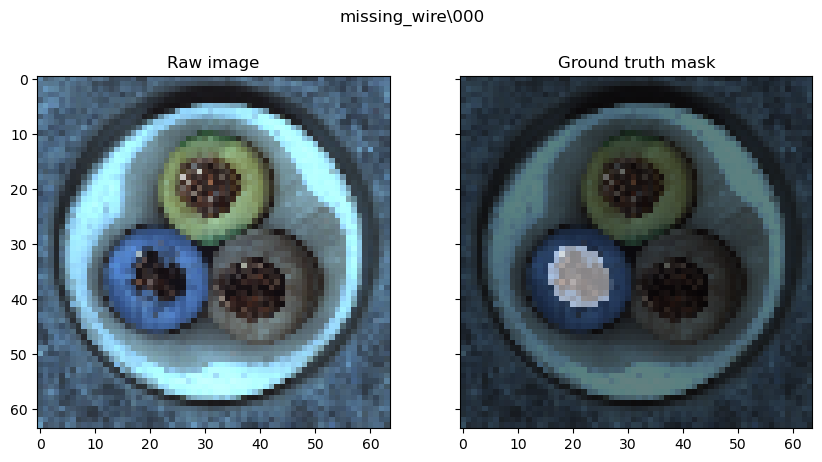

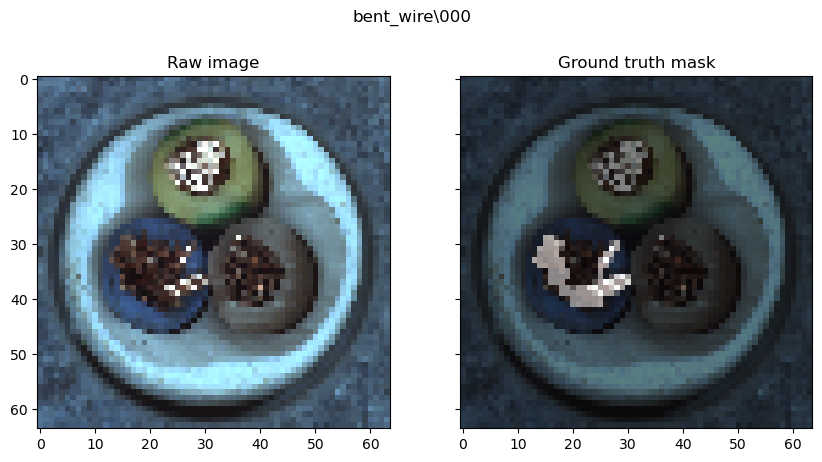

In [9]:
show_img_and_mask(img1, mask1, ex_name1)
show_img_and_mask(img2, mask2, ex_name2)

## Load pre-trained model

In [10]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")
IMAGE_SIZE = 64
PATCH_SIZE = 4
print(f"Number of patch features: {IMAGE_SIZE**2 // PATCH_SIZE}")
VIT_DIM = 256
MLP_DIM = 256
DEPTH = 2
NUM_HEADS = 8


# Load pretrained model
model = vit.SimpleViT(
    image_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = VIT_DIM,
    depth = DEPTH,
    heads = NUM_HEADS,
    mlp_dim = 512
).to("cpu")

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_pretrained_0.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])

# Freeze pretrained parameters
for p in model.parameters():
     p.requires_grad = False

# Discard fully-connected head, and substitute for a trainable fresh one
model.linear_head[-1] = nn.Sequential(
    nn.Linear(VIT_DIM, MLP_DIM),
    nn.ReLU(),
    nn.Linear(MLP_DIM, 1)
)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_frozen_parameters(model):
    return sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

model

Number of patch features: 1024
Loaded model, epoch:16, loss:3.3293343412990386
Trainable params: 66049
Frozen params: 1589504


SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=256, bias=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Linear(in_features=512, out_features=256, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=512, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
      )
      (1): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_aff

## Fine tuning routine

In [11]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        inputs, targets = batch["inputs"], batch["labels"]
        inputs, targets = inputs.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(inputs)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets.float())
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)
    data_category = kwargs.get("data_category", "noname")

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(CHECKPOINT_PATH, f"simple_vit_ft_{data_category}.pt")) # Fetch category name from Dataset definition

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            inputs, targets = batch["inputs"], batch["labels"]
            inputs, targets = inputs.to(device), targets.to(device)
    
            # print(f"Batch - Input: {inputs.shape, type(inputs), inputs.dtype} Target: {targets.shape, type(targets), targets.dtype}")

            model.zero_grad() # initialize gradients to zero
            logits = model(inputs) # forward pass

            # print(f"Logits - {logits.shape}, {type(logits)}, {logits.dtype}")

            loss = loss_fn(logits, targets.float()) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = torch.sigmoid(logits)
                pred_cats = preds > 0.5
                acc = (pred_cats == targets).float().mean()
    
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [15]:
# Define training parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 80
print("BATCH SIZE: ", BATCH_SIZE)
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_ratio)) # Account for class imbalance

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

BATCH SIZE:  32
CHECKPOINT PATH:  ..\results\vit_finetuning
Total parameters: 6.60e+04
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   28012 KB |  265058 KB |     846 MB |     819 MB |
|       from large pool |   13824 KB |  251392 KB |     831 MB |     817 MB |
|       from small pool |   14188 KB |   14698 KB |      15 MB |       1 MB |
|---------------------------------------------------------------------------|
| Active memory         |   28012 KB |  26

In [16]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer,
                                               loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE,
                                               data_category=CATEGORY)

# # Training the complete model
# temp1, temp2, temp3, temp4 = fit(model, train_dataloader, val_dataloader, optimizer,
#                                  loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)

# train_loss += temp1
# val_loss += temp2
# train_acc += temp3
# val_acc += temp4



Epoch 1/80


loss = 1.039 | acc = 0.469:  11%|█         | 1/9 [00:01<00:10,  1.34s/it]

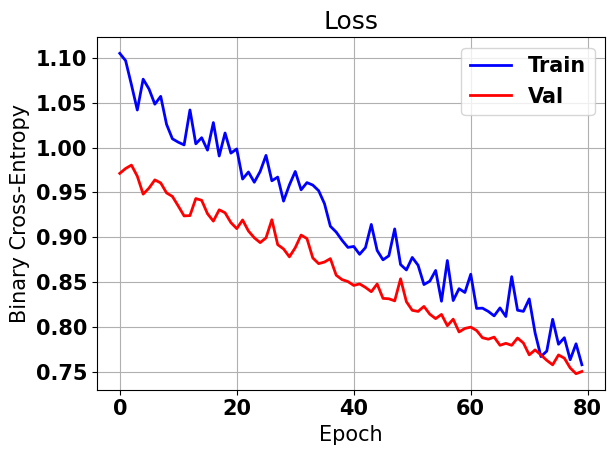

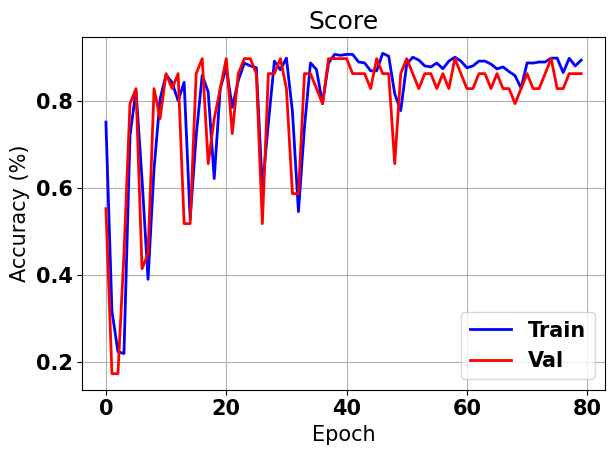

In [16]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [13]:
LEARNING_RATE = 1e-5
NUM_EPOCHS = 20

for p in model.parameters():
    p.requires_grad = True


print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

Trainable params: 1655553
Frozen params: 0


In [14]:
# Training the complete model
temp1, temp2, temp3, temp4 = fit(model, train_dataloader, val_dataloader, optimizer,
                                 loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)

train_loss += temp1
val_loss += temp2
train_acc += temp3
val_acc += temp4



Epoch 1/20


loss = 0.930 | acc = 0.846: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s] 


Train loss: 3.895 | train acc = 0.670


loss = 1.165 | acc = 0.276: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Validation loss: 1.165 | val acc = 0.276

Epoch 2/20


loss = 0.941 | acc = 0.846: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Train loss: 1.075 | train acc = 0.308


loss = 1.246 | acc = 0.724: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Validation loss: 1.246 | val acc = 0.724

Epoch 3/20


loss = 1.221 | acc = 0.308: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Train loss: 1.104 | train acc = 0.727


loss = 1.160 | acc = 0.276: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Validation loss: 1.160 | val acc = 0.276

Epoch 4/20


loss = 1.096 | acc = 0.769: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Train loss: 1.074 | train acc = 0.355


loss = 1.179 | acc = 0.724: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Validation loss: 1.179 | val acc = 0.724

Epoch 5/20


loss = 1.431 | acc = 0.615: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Train loss: 1.103 | train acc = 0.771


loss = 1.171 | acc = 0.276: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Validation loss: 1.171 | val acc = 0.276

Epoch 6/20


loss = 1.340 | acc = 0.385: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Train loss: 1.093 | train acc = 0.229


loss = 1.158 | acc = 0.276: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Validation loss: 1.158 | val acc = 0.276

Epoch 7/20


loss = 0.986 | acc = 0.154: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Train loss: 1.090 | train acc = 0.209


loss = 1.180 | acc = 0.724: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Validation loss: 1.180 | val acc = 0.724

Epoch 8/20


loss = 0.925 | acc = 0.846: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


Train loss: 1.075 | train acc = 0.791


loss = 1.244 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Validation loss: 1.244 | val acc = 0.724

Epoch 9/20


loss = 0.961 | acc = 0.154: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train loss: 1.058 | train acc = 0.692


loss = 1.162 | acc = 0.276: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Validation loss: 1.162 | val acc = 0.276

Epoch 10/20


loss = 0.982 | acc = 0.154: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train loss: 1.062 | train acc = 0.209


loss = 1.163 | acc = 0.276: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Validation loss: 1.163 | val acc = 0.276

Epoch 11/20


loss = 0.814 | acc = 0.923: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train loss: 1.044 | train acc = 0.324


loss = 1.195 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Validation loss: 1.195 | val acc = 0.724

Epoch 12/20


loss = 1.125 | acc = 0.769: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Train loss: 1.093 | train acc = 0.784


loss = 1.226 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Validation loss: 1.226 | val acc = 0.724

Epoch 13/20


loss = 0.996 | acc = 0.154: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Train loss: 1.071 | train acc = 0.495


loss = 1.156 | acc = 0.276: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Validation loss: 1.156 | val acc = 0.276

Epoch 14/20


loss = 1.246 | acc = 0.692: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


Train loss: 1.093 | train acc = 0.420


loss = 1.183 | acc = 0.724: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Validation loss: 1.183 | val acc = 0.724

Epoch 15/20


loss = 1.406 | acc = 0.615: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Train loss: 1.097 | train acc = 0.771


loss = 1.175 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Validation loss: 1.175 | val acc = 0.724

Epoch 16/20


loss = 1.095 | acc = 0.231: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Train loss: 1.079 | train acc = 0.279


loss = 1.155 | acc = 0.276: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Validation loss: 1.155 | val acc = 0.276

Epoch 17/20


loss = 1.094 | acc = 0.769: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Train loss: 1.072 | train acc = 0.364


loss = 1.189 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Validation loss: 1.189 | val acc = 0.724

Epoch 18/20


loss = 1.266 | acc = 0.692: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Train loss: 1.085 | train acc = 0.777


loss = 1.191 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Validation loss: 1.191 | val acc = 0.724

Epoch 19/20


loss = 0.836 | acc = 0.077: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Train loss: 1.045 | train acc = 0.676


loss = 1.166 | acc = 0.276: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Validation loss: 1.166 | val acc = 0.276

Epoch 20/20


loss = 1.394 | acc = 0.615: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Train loss: 1.096 | train acc = 0.494


loss = 1.177 | acc = 0.724: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Validation loss: 1.177 | val acc = 0.724


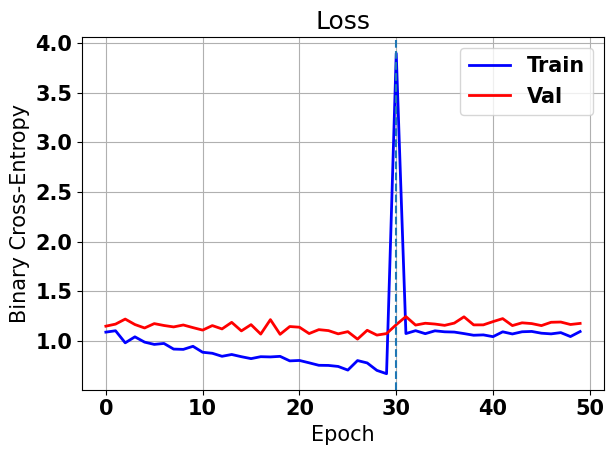

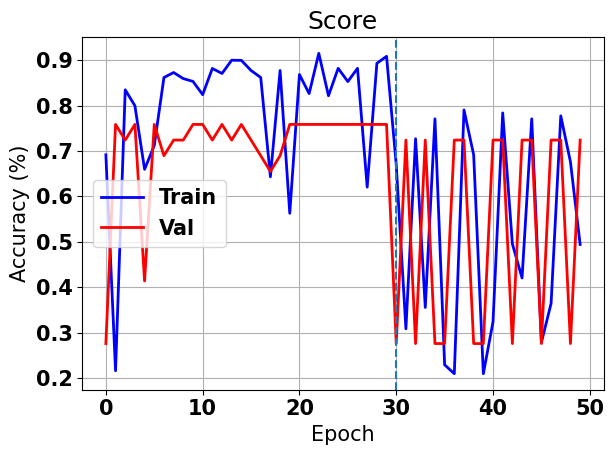

In [15]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.axvline(x=30, ls="--") # Frozen layers release
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.axvline(x=30, ls="--") # Frozen layers release
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize attention layers
def predict_with_attention(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))
    image_size = kwargs.get("image_size", 64)

    images, labels, results, attn_weights = [], [], [], []
    ground_truths = []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets, ground_truth = batch["inputs"], batch["labels"], batch["ground_truth"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits, attns = model(data) # attns: (batch x layers x heads x patch x patch)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5

        attns = attns.mean(dim=2) # average over heads
        attns_prod = attns[:, 0] # recursively multiply attentions
        for i in range(1, attns.shape[1]):
            attns_prod = torch.matmul(attns_prod, attns[:, i])

        images.append(data)
        labels.append(targets)
        results.append(pred_cats)
        attn_weights.append(attns_prod)

        t = transforms.Resize(image_size)
        ground_truths.append(t(ground_truth)[:, 0, ...])

    images = torch.concat(tuple([image for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))
    attn_weights = torch.concat(tuple([attn for attn in attn_weights]))
    ground_truths = torch.concat(tuple([gt for gt in ground_truths]))


    return images, labels, results, attn_weights, ground_truths

In [18]:
# Load pretrained model
model = vit.SimpleViT(
    image_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = VIT_DIM,
    depth = DEPTH,
    heads = NUM_HEADS,
    mlp_dim = 512
).to("cpu")


model.linear_head[-1] = nn.Sequential(
    nn.Linear(VIT_DIM, MLP_DIM),
    nn.ReLU(),
    nn.Linear(MLP_DIM, 1)
)

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_ft_bottle_0.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])


model = Recorder(model) # set up model to return attention weights in forward pass
images, labels, pred_cats, attns, gts = predict_with_attention(model, train_dataloader, image_size=IMAGE_SIZE)
model = model.eject() # remove hooks from forward pass


print(images.shape, labels.shape, pred_cats.shape, attns.shape, gts.shape)

Loaded model, epoch:19, loss:0.7477525472640991


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]

torch.Size([205, 3, 64, 64]) torch.Size([205, 1]) torch.Size([205, 1]) torch.Size([205, 256, 256]) torch.Size([205, 64, 64])


In [19]:
%matplotlib inline
# Refs: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook

def plot_attentions(images, labels, pred_cats, attns, start_idx=0, n_rows=5, **kwargs):

    image_size = kwargs.get("image_size", 64)
    patch_size = kwargs.get("patch_size", 4)
    ground_truths = kwargs.get("ground_truths", None)

    fig, ax = plt.subplots(1, n_rows, figsize=(8, 3))
    with plt.rc_context(rc={'font.size': 9}):
        for i in range(start_idx, start_idx + 5):
            ca = ax[i % 5]
            # Plot correct predictions for anomalous objects
            img = images[i]
            img_label = labels[i]
            pred_label = pred_cats[i]
            resize = transforms.Resize(image_size)
            
            attns_raw = attns[i]
            attns_vals = attns_raw[-1]
            mask = attns_vals.reshape(image_size//patch_size, image_size//patch_size)
            mask = resize(mask.unsqueeze(0)).squeeze()
            mask = mask.detach().numpy()
            mask = (mask - mask.min())/(mask.max() - mask.min())

            img_perm = torch.permute(img, (1, 2, 0)).cpu().numpy()
            ca.imshow(img_perm, zorder=0)
            ca.imshow(mask, alpha=0.7, cmap="viridis", zorder=2)

            # Plot ground truth mask if provided when anomalous
            if ground_truths is not None and img_label.item() > 0:
                ca.imshow(ground_truths[i], alpha=0.4*ground_truths[i]/255, cmap="Greys_r", zorder=1)
        
            if pred_label.int().item() == img_label.item():
                ca.set_title(f"{pred_label.int().item()} / {img_label.item()}", color="green")
            else:
                ca.set_title(f"{pred_label.int().item()} / {img_label.item()}", color="red")

            ca.set_axis_off()
        
        fig.tight_layout()

C:\Users\fcoel\AppData\Local\Temp\ipykernel_11440\2556562343.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, n_rows, figsize=(8, 3))


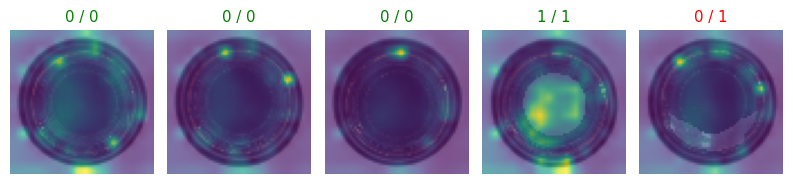

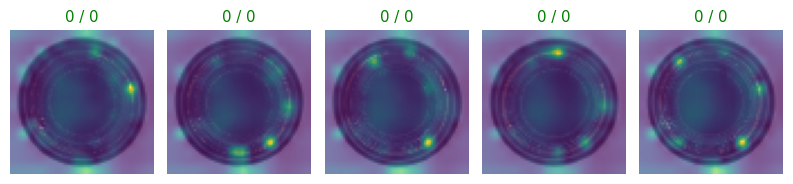

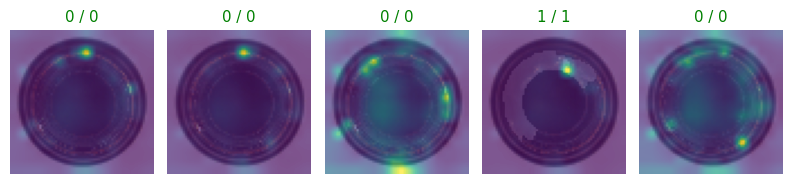

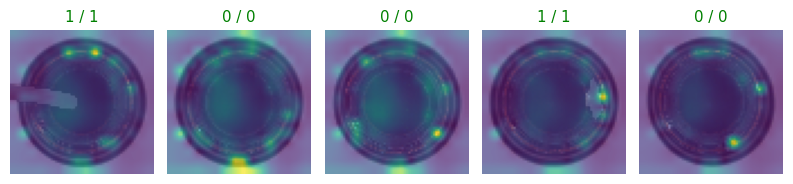

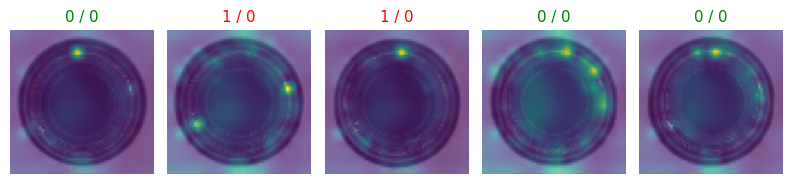

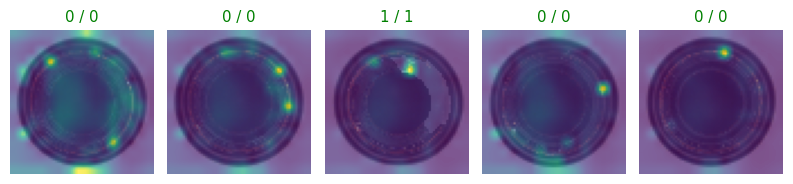

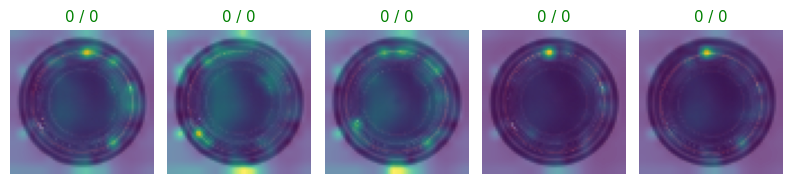

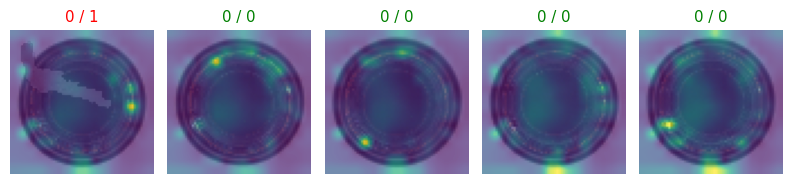

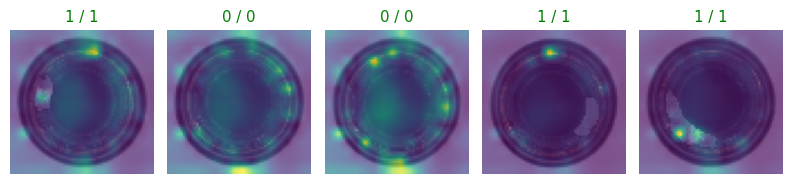

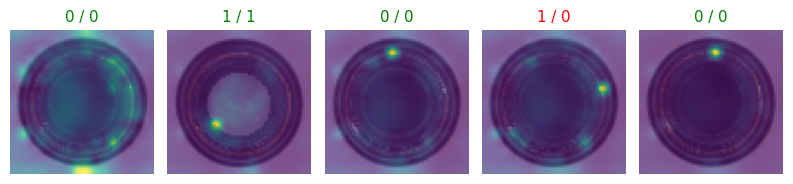

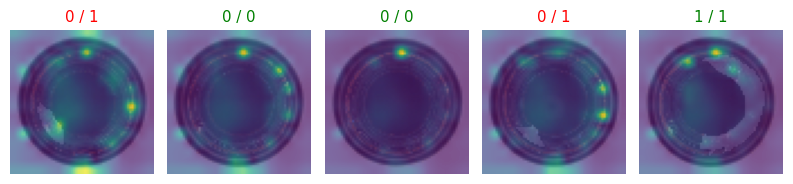

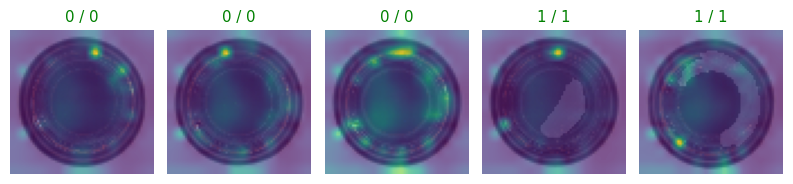

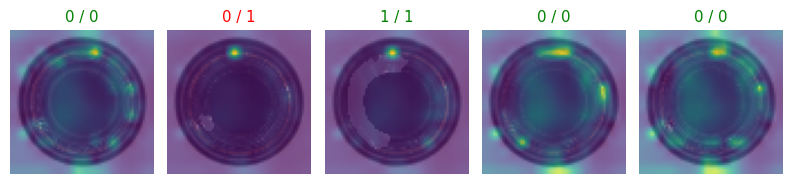

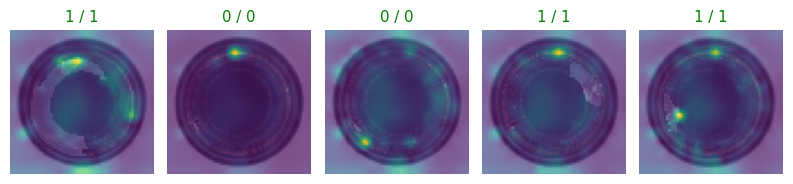

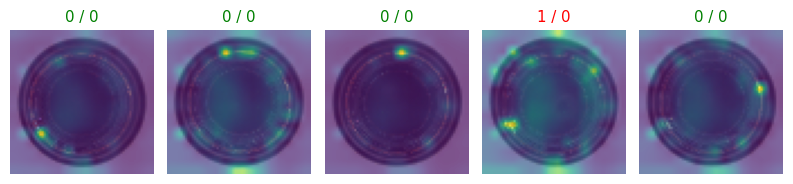

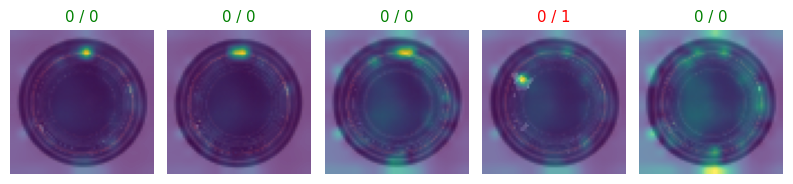

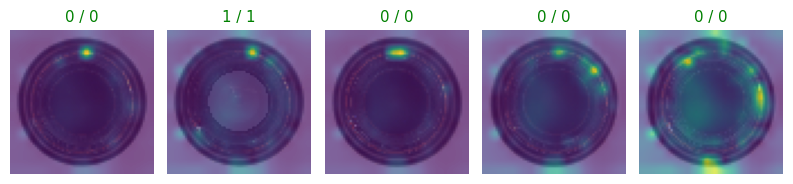

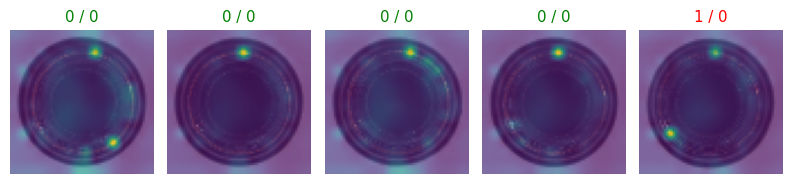

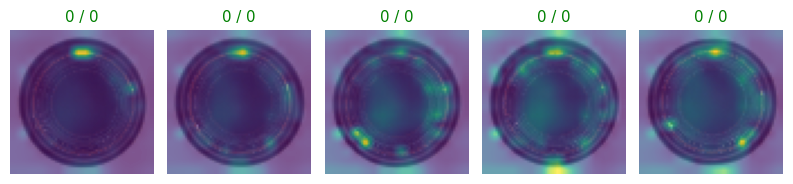

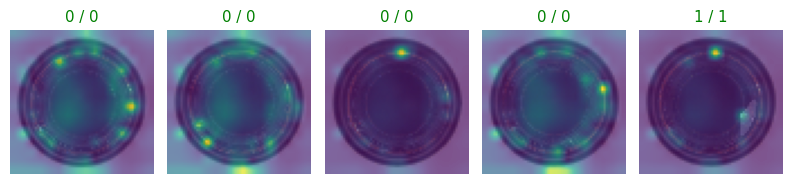

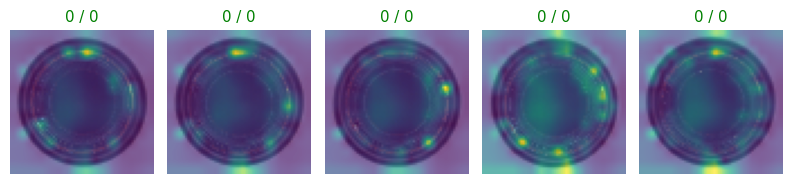

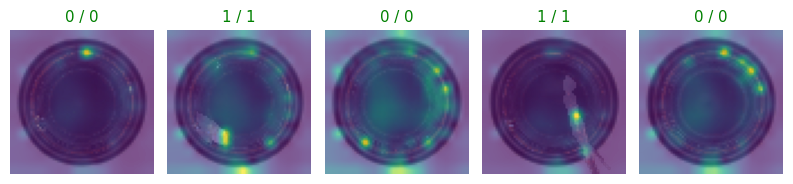

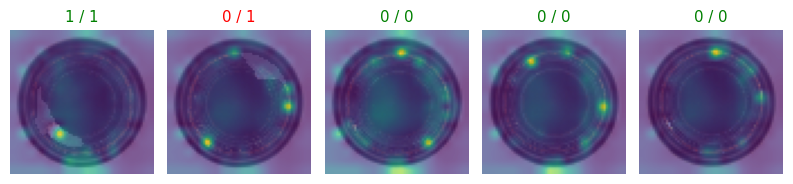

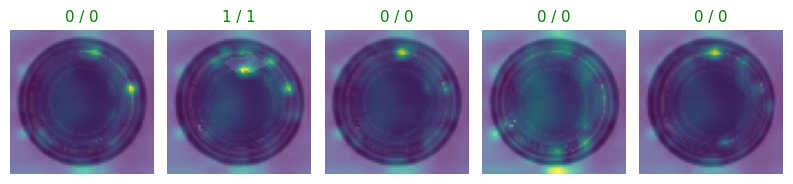

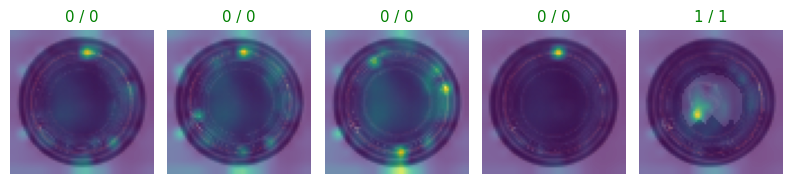

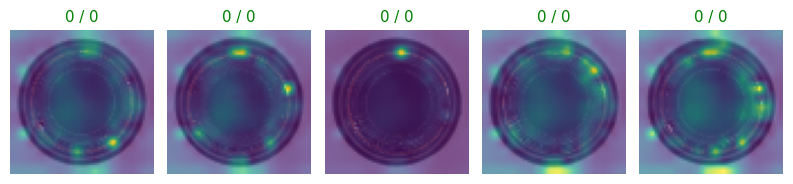

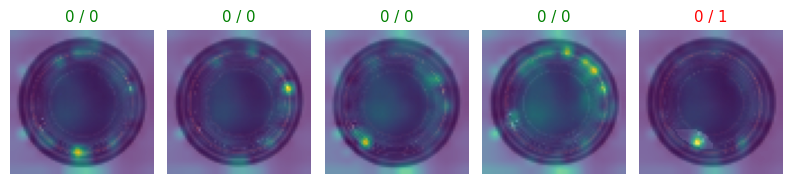

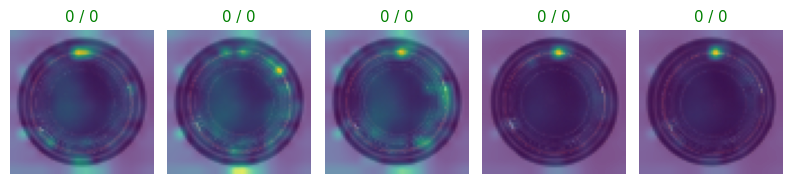

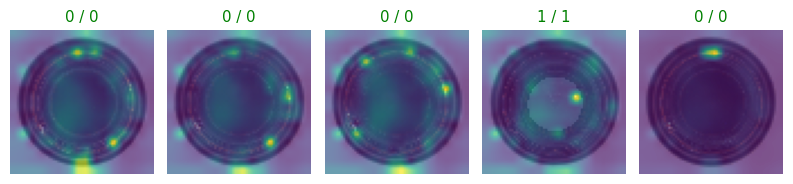

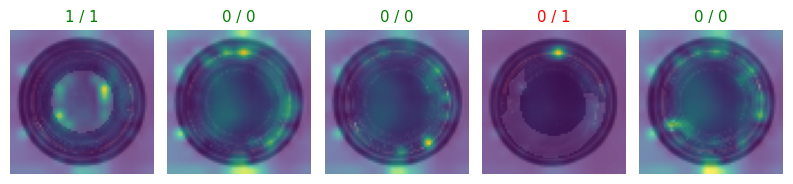

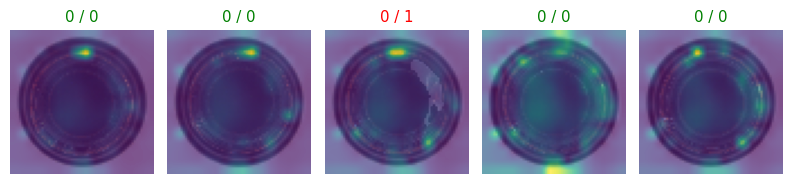

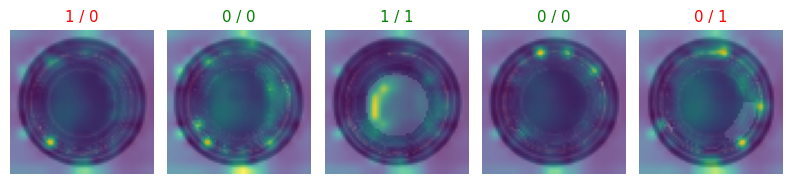

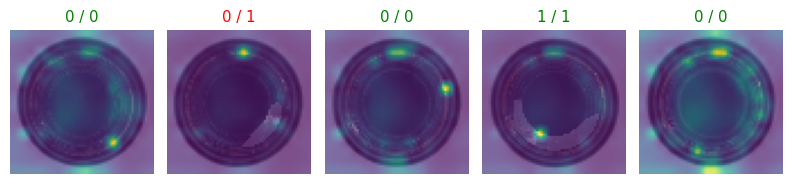

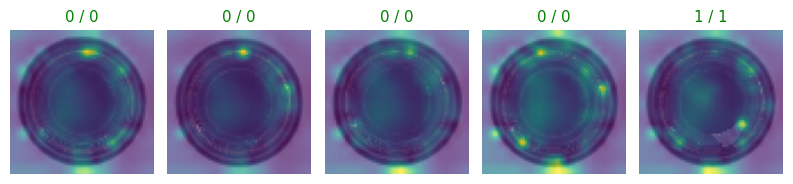

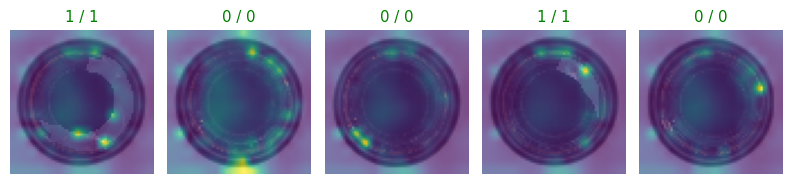

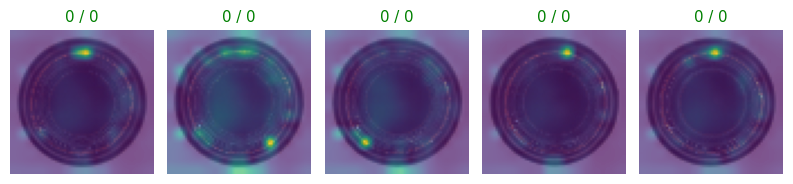

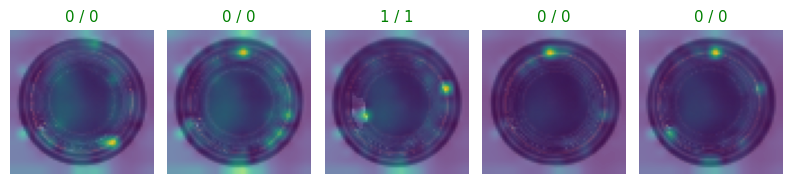

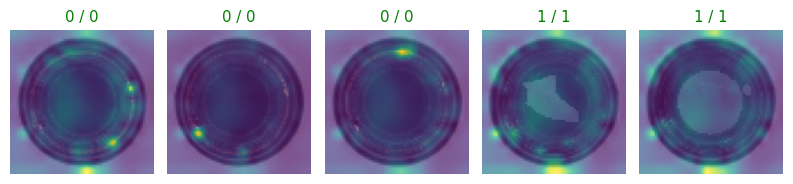

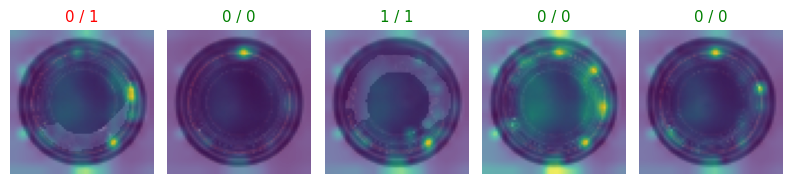

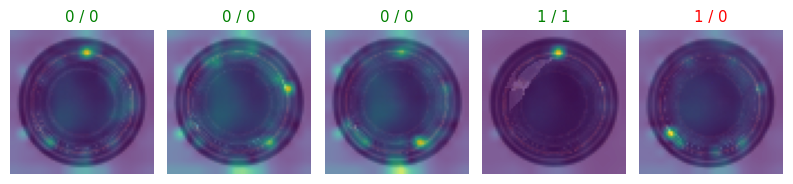

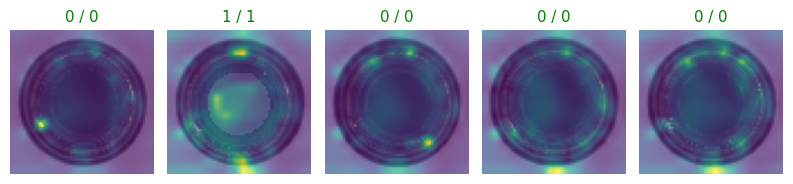

In [20]:
for i in range(0, images.shape[0]-1, 5):
    plot_attentions(images, labels, pred_cats, attns, start_idx=i,
                    image_size=IMAGE_SIZE, patch_size=PATCH_SIZE, ground_truths=gts)